This script shows how to create fig2 from the main text


It takes as input the 'Cambray_results_merged.csv' file, computed with the script 'Inference_Cambray_dataset.py'

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.gridspec as gsp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import scipy.stats as stats 
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))  
from scipy.special import gamma, factorial,digamma
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy.special as sp 

In [2]:
# Experimental parameters
FLUORESCENCE_MAX=10**6
BINS=16
Partition=np.logspace(0,np.log10(FLUORESCENCE_MAX),BINS)
Part_conv=np.insert(Partition,0,0)
Mean_expression_bins=np.array([(Part_conv[j+1]+Part_conv[j])/2 for j in range(BINS)])

def data_transformation_bins(X):  #New representation of the data enabling the method of moments
    X=X.astype(int)
    T=np.repeat(Mean_expression_bins,X)
    return(T)

# Processing inference data

##  Loading and filtering data

In [3]:
df=pd.read_csv('Cambray_results_merged.csv')
df.head()

,a_MLE,b_MLE,a_std,b_std,mu_MLE,sigma_squared_ML,mu_std,sigma_std,a_MOM,b_MOM,mu_MOM,sigma_sqaured_MOM,Inference_grade,Score
0,2.404087,121.798353,0.119261,6.742133,292.813851,35664.244616,5.395311,54.298924,1.057295,326.853754,345.580796,112954.380403,1.0,0.0
1,2.267665,284.367260,0.094870,13.568980,644.849546,183374.098797,10.626137,122.805793,1.132349,662.175445,749.813755,496508.256887,1.0,0.0
2,1.817198,76.218898,0.297459,14.252253,138.504839,10556.686172,7.394141,68.878609,1.837531,87.797952,161.331443,14164.570310,1.0,0.0
3,1.866300,495.668449,0.105642,32.826042,925.066245,458526.151342,19.901432,250.609175,1.174496,916.671280,1076.626665,986912.743122,1.0,0.0
4,2.266506,16.121358,0.164282,1.253377,36.539159,589.060883,0.637619,4.575069,0.995651,42.651648,42.466154,1811.251455,1.0,0.0


In [4]:
Nj=np.load('Nj_merged.npy')
Sij=np.load('Sij_merged.npy')
READS=np.array([ 1460332.,  2109815.,  2335533.,  3210865.,  4303324.,  5864139.,7490610.,  9922865., 12976416., 15188644., 19094267., 23689418.,23664179., 21895118., 17576043.,  5519053.])

Enrich=Nj/READS
Nihat=np.multiply(Sij,Enrich)
Nihat=np.around(Nihat)
Nihat=Nihat.astype(int)
df=pd.concat([df, pd.DataFrame(np.sum(Nihat,axis=1),columns=['Seq_Depth'])], axis=1)   

In [5]:
#Is ML inference worth it? keep only the sequences satisfying the following conditions:
df=df[df['Inference_grade']<3] # has the genetic construct been sequenced?
df=df[df['Seq_Depth']>50]  #has the construct been sufficiently sequenced?
df=df[df['sigma_squared_ML']<1.0e9] # the gamma distribution assumption might be violated with highly expressed constructs
df=df[(df['Score']<0.6) ] #Scoring of the data- How lopsided is the read count? We keep constructs only if less than 60% of the reads are not in the first or last bin ? (the binning induces a border effect that hinders inference)
print('We removed ',150000-len(df),' sequences after this inference quality check, accounting for ',100*(150000-len(df))/150000,'% of the original dataset')


We removed  9858  sequences after this inference quality check, accounting for  6.572 % of the original dataset


# Plotting data

- Comparing different estimates on the mean protein copy number $\mu$

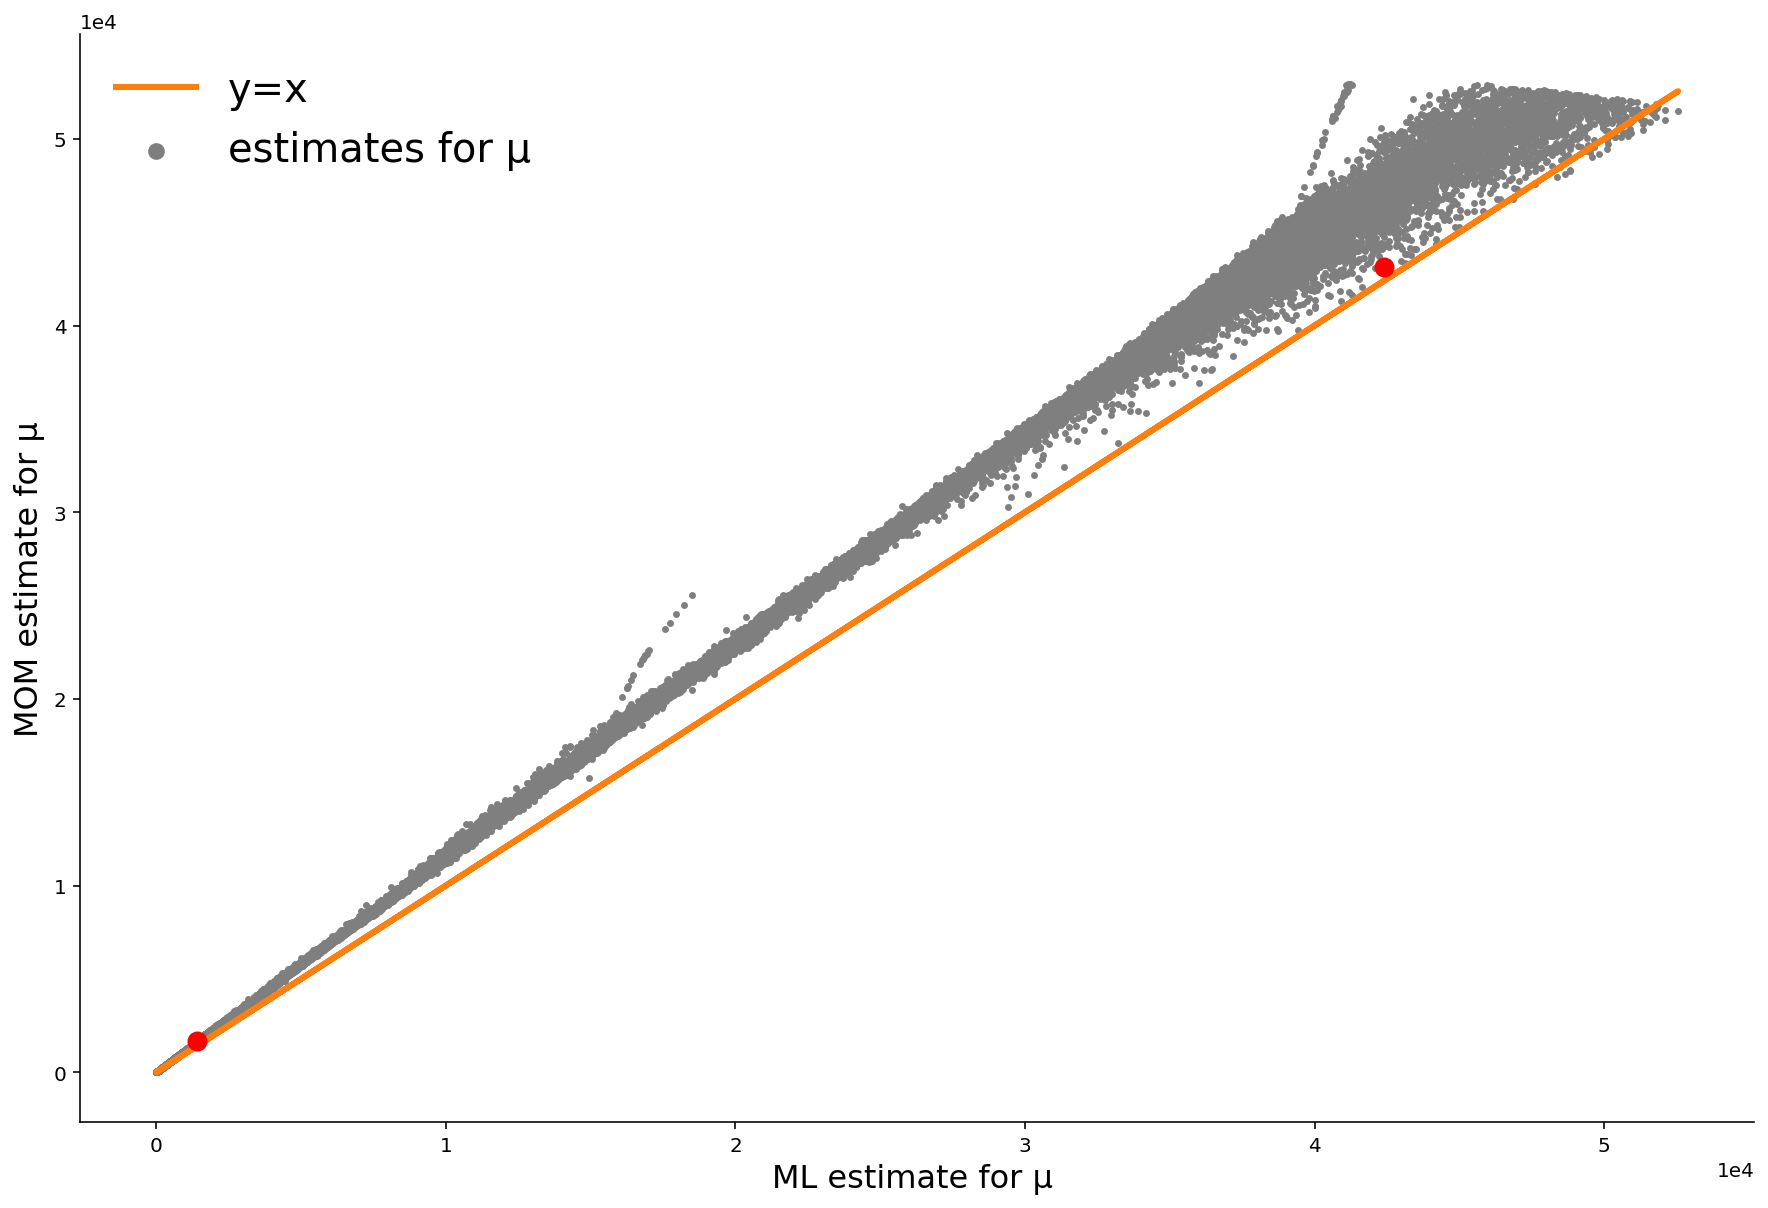

In [63]:
#Specifying two relevant genetic constructs
i,j=972,12679
ml1 =df.loc[[i]].values[0][4]
mom1 =df.loc[[i]].values[0][10]
ml2 =df.loc[[j]].values[0][4]
mom2 =df.loc[[j]].values[0][10]

X=df['mu_MLE']
Y=df['mu_MOM']
fig_dims = (15, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.scatter(X,Y,s=6,c='tab:grey',label='estimates for μ')
plt.plot(X,X,c='tab:orange',linewidth=3,label='y=x')
plt.xlabel('ML estimate for μ ',fontsize=16)
plt.ylabel('MOM estimate for μ',fontsize=16)
sns.despine()
plt.legend(frameon=False,fontsize=20,markerscale=3)
plt.ticklabel_format(axis="x",style="sci", scilimits=(0,0))
plt.ticklabel_format( axis='y',style="sci", scilimits=(0,0))
plt.plot(ml1, mom1, color='red', marker='o',markersize=9)
plt.plot(ml2, mom2, color='red', marker='o',markersize=9)
#plt.savefig('Cambray_comparison_Ml_mom_for_mu_972,12679.png',transparent=True,bbox_inches='tight',dpi=600)

Text(6000, 10000.0, '$\\langle \\mu_{MOM}-\\mu_{ML} \\rangle \\sim $1.2e+03')

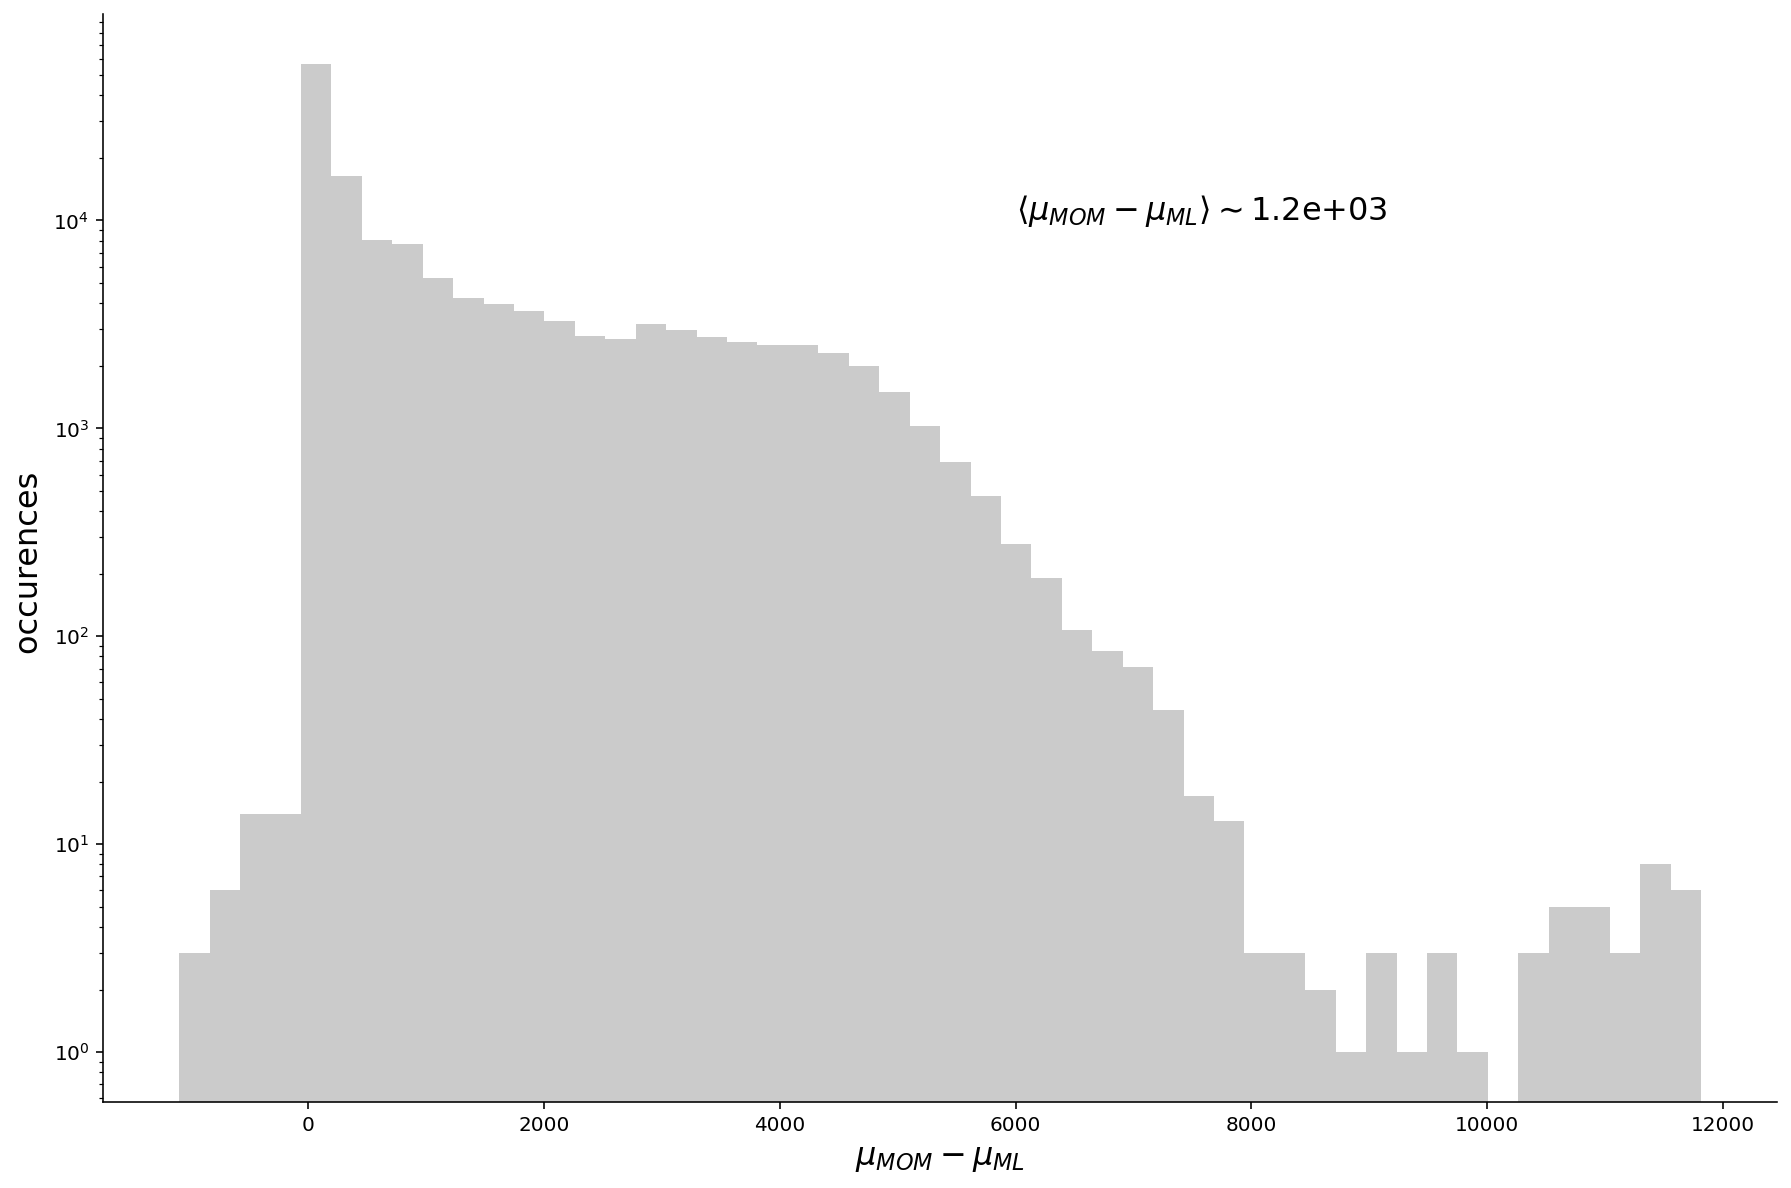

In [64]:
plt.figure(figsize=(15,10))
sns.distplot(Y-X,kde=False,color='tab:grey')
sns.despine()
plt.yscale('log')
plt.ylabel('occurences ',fontsize=16)
plt.xlabel('$\mu_{MOM}-\mu_{ML}$',fontsize=16)
approx_bias=np.format_float_scientific(round((Y-X).sum()/len(Y)),precision=1)
plt.text(6000, 1e4, r'$\langle \mu_{MOM}-\mu_{ML} \rangle \sim $%s'%approx_bias, fontsize=16)

- Comparing estimates on the protein copy number variance $\sigma^{2}$

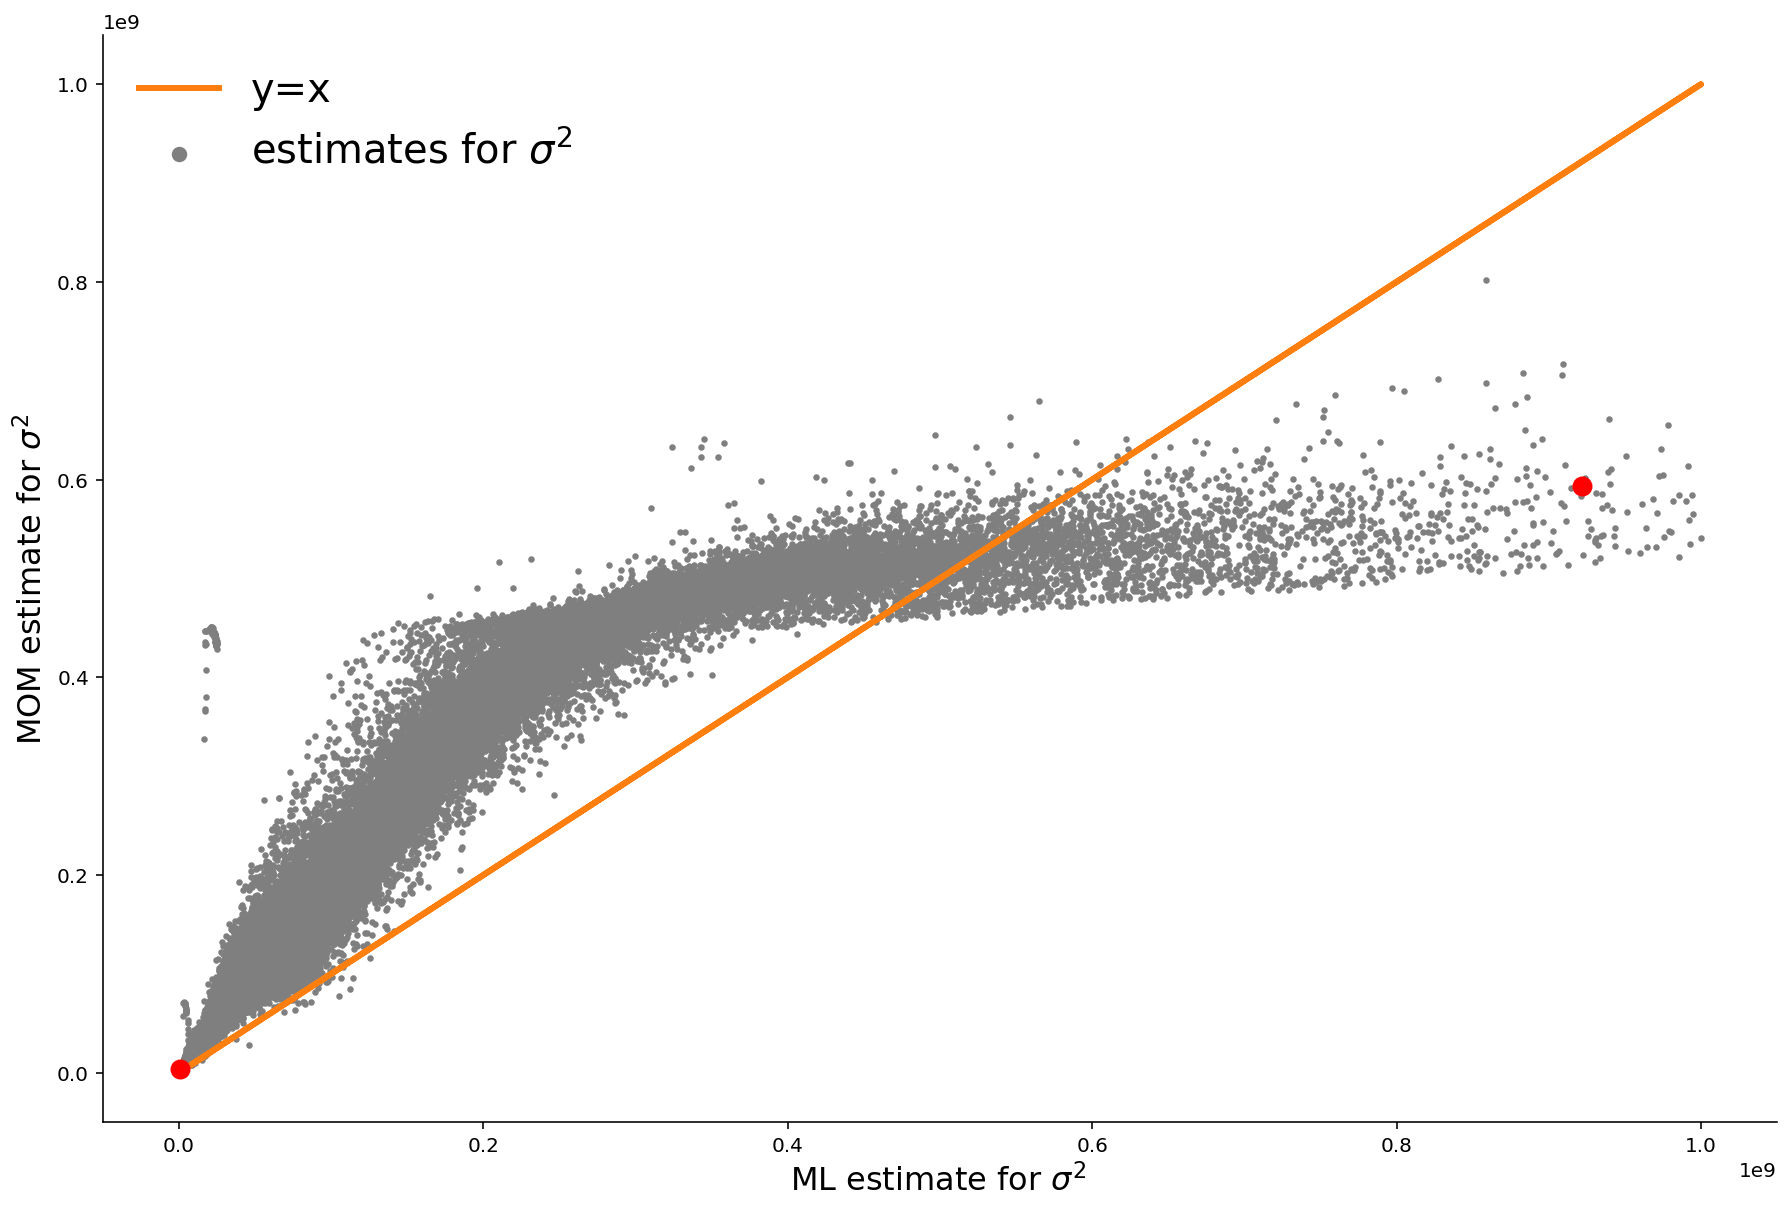

In [51]:
#Specifying two relevant genetic constructs
i,j=972,12679
ml1 =df.loc[[i]].values[0][5]
mom1 =df.loc[[i]].values[0][11]
ml2 =df.loc[[j]].values[0][5]
mom2 =df.loc[[j]].values[0][11]

X=df['sigma_squared_ML']
Y=df['sigma_sqaured_MOM']
fig_dims = (15, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.scatter(X,Y,s=5,c='tab:grey',label='estimates for $\sigma^{2}$',)
plt.plot(X,X,c='tab:orange',linewidth=3,label='y=x',)
plt.xlabel('ML estimate for $\sigma^{2}$ ',fontsize=16)
plt.ylabel('MOM estimate for $\sigma^{2}$',fontsize=16)
sns.despine()
plt.legend(frameon=False ,fontsize=20,markerscale=3)
plt.ticklabel_format(axis="x",style="sci", scilimits=(0,0))
plt.ticklabel_format( axis='y',style="sci", scilimits=(0,0))
plt.plot(ml1, mom1, color='red', marker='o',markersize=9)
plt.plot(ml2, mom2, color='red', marker='o',markersize=9)
#plt.savefig('Cambray_comparison_Ml_mom_for_sigma_972,12679.png',transparent=True,bbox_inches='tight',dpi=600)

Text(-400000000.0, 10000.0, '$\\langle \\sigma^{2}_{MOM}-\\sigma^{2}_{ML} \\rangle \\sim $3.2e+07')

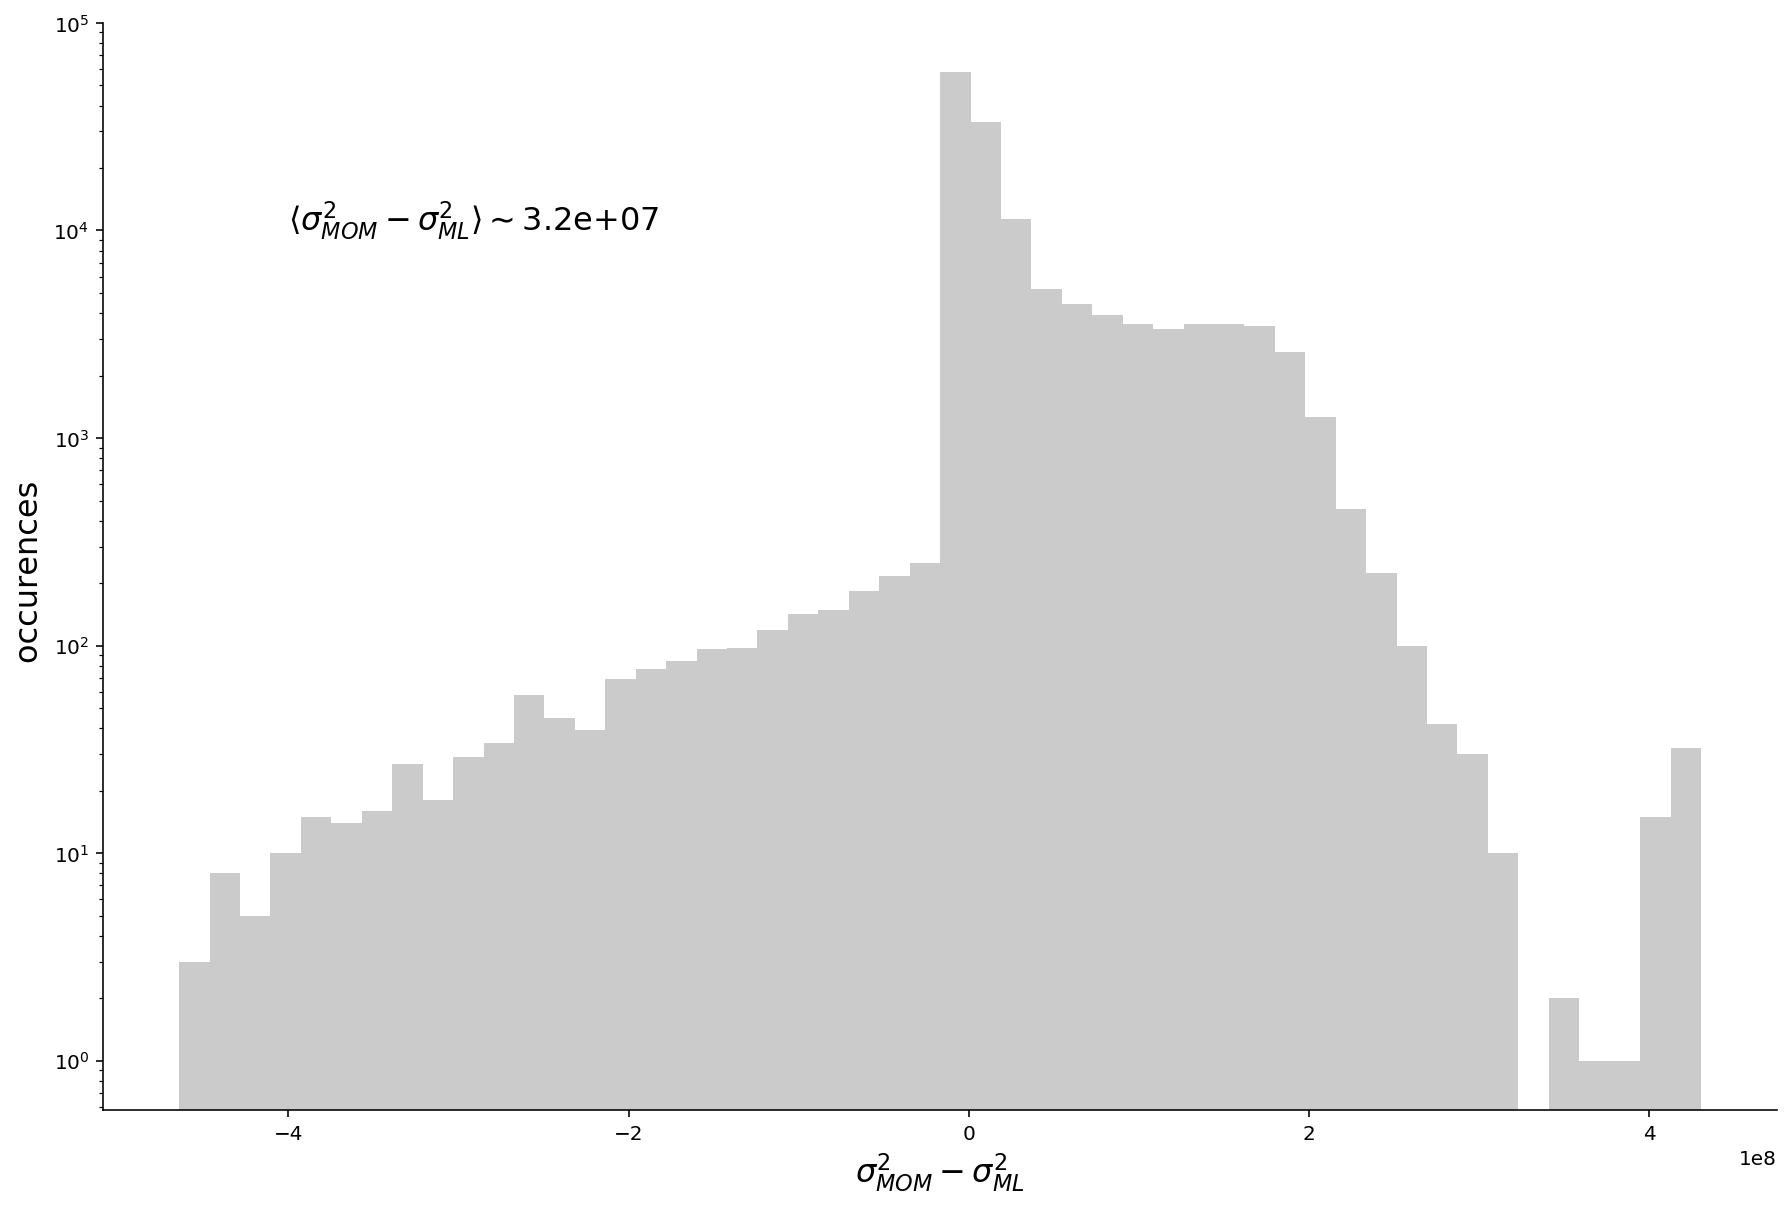

In [61]:
plt.figure(figsize=(15,10))
sns.distplot(Y-X,kde=False,color='tab:grey')
sns.despine()
plt.yscale('log')
plt.ylabel('occurences ',fontsize=16)
plt.xlabel('$\sigma^{2}_{MOM}-\sigma^{2}_{ML}$',fontsize=16)
approx_bias=np.format_float_scientific(round((Y-X).sum()/len(Y)),precision=1)
plt.text(-4e8, 1e4, r'$\langle \sigma^{2}_{MOM}-\sigma^{2}_{ML} \rangle \sim $%s'%approx_bias, fontsize=16)

- Visualising the two reconstructions: 

1.9554146823909693 216737.05666849407 3.132950357826695 137612.17278590336


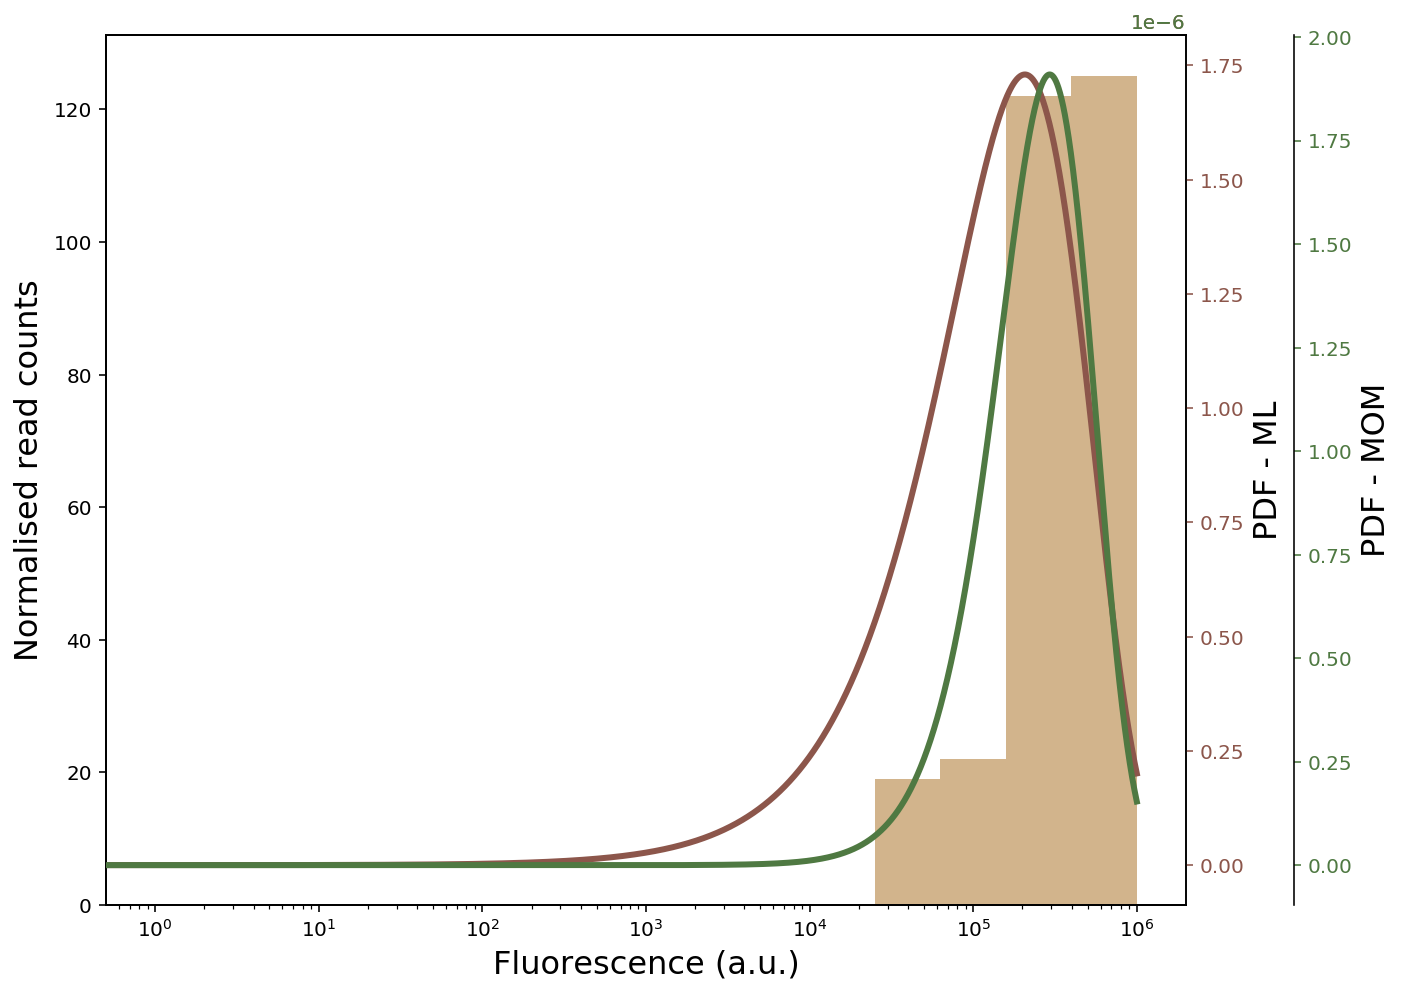

In [65]:
#Interesting constructs to choose from
#i=972
#i=7205
#i=28
i=12679

x = np.linspace(0, 1e6, 1000000)
a =dfc.loc[[i]].values[0][0]
b =(dfc.loc[[i]].values[0][1])*10
a2 = dfc.loc[[i]].values[0][8]
b2= (dfc.loc[[i]].values[0][9])*10

#Data
y_mle =stats.gamma.pdf(x, a, scale=b) # the normal pdf
y_mom=stats.gamma.pdf(x,a2,scale=b2)

#Graph
fig, ax = plt.subplots(figsize=(12,8))

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.1))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)
# And finally we get to plot things...
colors = ('tan','tab:brown', '#4f7942')
axes[0].hist(data_transformation_bins(Nihat[i,:]),bins=Partition,zorder=0,color='tan',label='Read count')
axes[1].plot(x, y_mle, label='ML reconstruction',linewidth=3,zorder=5,color='tab:brown')
axes[2].plot(x, y_mom, label='MOM reconstruction',linewidth=3,zorder=3,c='#4f7942')

axes[0].set_ylabel('Normalised read counts',fontsize=16)
axes[1].set_ylabel('PDF - ML',fontsize=16)
axes[2].set_ylabel('PDF - MOM',fontsize=16)
#axes[0].tick_params(axis='y', colors=color)
axes[1].tick_params(axis='y', colors=colors[1])
axes[2].tick_params(axis='y', colors=colors[2])
axes[0].set_xlabel('Fluorescence (a.u.)',fontsize=16)
axes[1].ticklabel_format(axis="y",style="sci", scilimits=(0,0))
axes[2].ticklabel_format(axis="y",style="sci", scilimits=(0,0))
plt.xscale('log')
print(a,b,a2,b2)
#plt.savefig('Comparison real datasetmom-mle-construct12679.png',transparent=True,bbox_inches='tight',dpi=600)
#plt.close()